Plot Microphysical Properties
========================

Go back to the [list of notebooks](../simple_usage.rst) if this is not what your are looking for

This notebook will guide the user on how to reproduce Fig 4 of the [Ori et al. 2021](https://gmd.copernicus.org/preprints/gmd-2020-359/) paper, and can also be used as a guide on how to get microphysical properties (mass, area and fallspeed) from snowScatt

First we start by loading some modules and defining useful functions that are gonna be needed for plotting and comparison with published literature

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from collections import OrderedDict
from IPython.core.debugger import set_trace
import snowScatt

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':11})

# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})

def stylize_axes(ax, xlabel, ylabel, xticks=None, yticks=None, xticklabels=None, yticklabels=None,changeyticks=False,xlims=None,ylims=None):
    """Customize axes spines, title, labels, ticks, and ticklabels."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.xaxis.set_tick_params(top=False, direction='out', width=1)
    ax.yaxis.set_tick_params(right=False, direction='out', width=1)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if xticks!=None:    
        ax.set_xticks(xticks)
    if yticks!=None:    
        ax.set_yticks(yticks)
    if xlims!=None:
        ax.set_xlim(xlims)
    if ylims!=None:
        ax.set_ylim(ylims)
    if xticklabels!=None:
        ax.set_xticklabels(xticklabels)
    if yticklabels!=None:
        ax.set_yticklabels(yticklabels)

litSnowPropDic = {}

#Mitchell 1996 "Use of mass- and area-dimensional power laws for determining precipitation particle terminal velocities"
litSnowPropDic["M96_mixS3"] = {"am": 0.0028*10.**(2.*2.1-3.), "bm":2.1, "minD":800e-6, "maxD":4500e-6, "aA": 0.2285*10.**(2.*1.88-4.) , "bA": 1.88}
litSnowPropDic["M96_sideplane"] = {"am": 0.0033*10.**(2.*2.2-3.), "bm":2.2, "minD":600e-6, "maxD":4100e-6, "aA": 0.2285*10.**(2.*1.88-4.) , "bA": 1.88}
litSnowPropDic["M96_polycrys"] = {"am": 0.00739*10.**(2.*2.45-3.), "bm":2.45, "minD":20e-6, "maxD":450e-6, "aA": 0.2285*10.**(2.*1.88-4.) , "bA": 1.88}

#Locatelli & Hobbs (1974) "Fall speeds and masses of solid precipitation particles"
litSnowPropDic["LH74_dendrite"]     = {"am": 0.073*10.**(3*1.4-6.), "bm":1.4, "minD":2e-3, "maxD":10e-3,  "av":0.8*10.**(3*0.16), "bv":0.16 }
litSnowPropDic["LH74_mixed"]        = {"am":0.037*10.**(3*1.9-6.) , "bm":1.9, "minD":1e-3, "maxD":3e-3,"minvD":0.2e-3,  "av":0.69*10.**(3*0.41), "bv":0.41 }
litSnowPropDic["LH74_sideplanes"]   = {"am":0.04*10.**(3*1.4-6.) , "bm":1.4, "minD":0.5e-3, "maxD":4.0e-3,  "av":0.82*10.**(3*0.12), "bv":0.12 }
litSnowPropDic["LH74_ldgraupel"]    = {"am":0.042*10.**(3*3.0-6.) , "bm":3.0, "minD":0.5e-3, "maxD":2.0e-3,  "av":1.16*10.**(3*0.46), "bv":0.46 }
litSnowPropDic["LH74_hdgraupel"]    = {"am":0.14*10.**(3*2.7-6.) , "bm":2.7, "minD":0.5e-3, "maxD":1.0e-3,  "av":1.5*10.**(3*0.37), "bv":0.37 }

for key in ["LH74_dendrite","LH74_mixed","LH74_sideplanes","LH74_ldgraupel","LH74_hdgraupel"]: #for some particles LH74 have different observed limits for m-D and v-D
    if not "minvD" in litSnowPropDic[key].keys():
        litSnowPropDic[key]["minvD"]    = litSnowPropDic[key]["minD"]
    if not "maxvD" in litSnowPropDic[key].keys():
        litSnowPropDic[key]["maxvD"]    = litSnowPropDic[key]["maxD"]

def litSnowProp(diameters,particle,velocity_model="Boehm92"):

    mass    = litSnowPropDic[particle]["am"] * diameters ** litSnowPropDic[particle]["bm"]
    mass    = np.ma.masked_where(np.logical_or(diameters<litSnowPropDic[particle]["minD"],diameters>litSnowPropDic[particle]["maxD"]),mass)

    if "av" in litSnowPropDic[particle].keys():
        vel = litSnowPropDic[particle]["av"] * diameters ** litSnowPropDic[particle]["bv"]
        vel     = np.ma.masked_where(np.logical_or(diameters<litSnowPropDic[particle]["minvD"],diameters>litSnowPropDic[particle]["maxvD"]),vel)
    else:
        vel = np.ones_like(mass) * np.nan

    if "aA" in litSnowPropDic[particle].keys():
        area    = litSnowPropDic[particle]["aA"] * diameters ** litSnowPropDic[particle]["bA"]
        area    = np.ma.masked_where(np.logical_or(diameters<litSnowPropDic[particle]["minD"],diameters>litSnowPropDic[particle]["maxD"]),area)
    else:
        area = np.ones_like(mass) * np.nan

    return mass, vel, area

Now we define an array of property names (labels in the snowLibrary). We are gonna plot the microphysical properties for all of them. We put also some published results from observations along with the results from snowScatt for comparison purposes

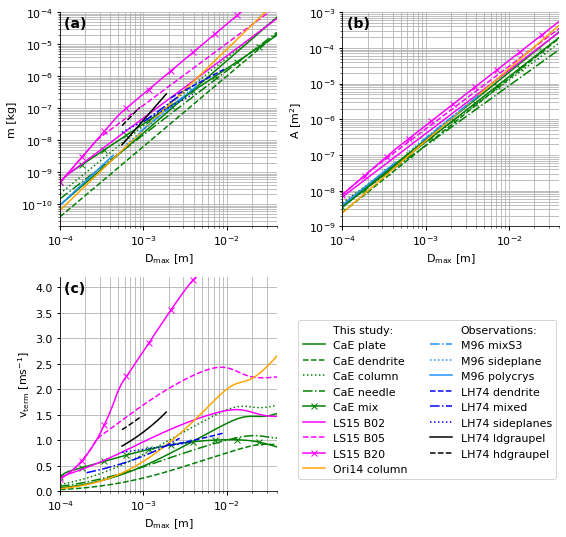

In [2]:
########################################################################################################    
# The first section explains how to use snowScatt             Now it is just decoration with observation data and plotting                                         #
########################################################################################################

particle_types = ["vonTerzi_plate","vonTerzi_plate","vonTerzi_dendrite","vonTerzi_column","vonTerzi_needle","vonTerzi_mixcoldend","Leinonen15tabB02","Leinonen15tabB05","Leinonen15tabB20", "Ori_collColumns", "Ori_collColumns"]
particle_labels = ["This study:","CaE plate","CaE dendrite","CaE column","CaE needle","CaE mix","LS15 B02","LS15 B05","LS15 B20", "Ori14 column", "Observations:"]

diameters   = np.logspace(-4,np.log10(4e-2))

#for plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
#               plate,dendrite,column,needle,mix2,tabA02,tabA05,tabA20
linestyles  =   ["None","-","--",      ":",  "-.",    "-","-",   "--" , "-", "-","None", "-.",":","-","--","-.",":","-","--"]
markers     =   ["None","", ""  ,      "" ,   "" ,    "x", "",      "", "x","","None", "","","","","","","",""]
colors      =   ["None", "g", "g",      "g",   "g",    "g" ,"magenta","magenta", "magenta","orange","None","dodgerblue","dodgerblue","dodgerblue","blue","blue","blue","black","black"]

#plot modelled particles
for i_p,particle_type in enumerate(particle_types):

    #get particle properties from the database
    mass, vel, area = snowScatt.snowMassVelocityArea(diameters, particle_type) # This is the function to CALL!!

    axes[0,0].loglog(diameters,mass,linestyle=linestyles[i_p],marker=markers[i_p],markevery=5,color=colors[i_p],label=particle_labels[i_p]) 
    axes[0,1].loglog(diameters,area,linestyle=linestyles[i_p],marker=markers[i_p],markevery=5,color=colors[i_p],label=particle_labels[i_p]) 
    axes[1,0].semilogx(diameters,vel,linestyle=linestyles[i_p],marker=markers[i_p],markevery=5,color=colors[i_p],label=particle_labels[i_p])

########################################################################################################    
# Now it is just decoration with observation data and plotting                                         #
########################################################################################################

#plot observations 
particle_types  = ["M96_mixS3","M96_sideplane","M96_polycrys","LH74_dendrite","LH74_mixed","LH74_sideplanes","LH74_ldgraupel","LH74_hdgraupel"]
particle_labels  = ["M96 mixS3","M96 sideplane","M96 polycrys","LH74 dendrite","LH74 mixed","LH74 sideplanes","LH74 ldgraupel","LH74 hdgraupel"]

for i_pLit,particle in enumerate(particle_types):

    mass,vel, area = litSnowProp(diameters,particle,velocity_model="Boehm92")

    axes[0,0].loglog(diameters,mass,linestyle=linestyles[i_p+i_pLit+1],marker=markers[i_p+i_pLit+1],color=colors[i_p+i_pLit+1],label=particle_labels[i_pLit]) 
    axes[0,1].loglog(diameters,area,linestyle=linestyles[i_p+i_pLit+1],marker=markers[i_p+i_pLit+1],color=colors[i_p+i_pLit+1],label=particle_labels[i_pLit]) 

    if "av" in litSnowPropDic[particle].keys(): 
        axes[1,0].semilogx(diameters,vel,linestyle=linestyles[i_p+i_pLit+1],marker=markers[i_p+i_pLit+1],color=colors[i_p+i_pLit+1],label=particle_labels[i_pLit]) 

#formatting the plots
xlabels = [r'$D_{max}$ [m]', r'$D_{max}$ [m]',r'$D_{max}$ [m]', '']
ylabels = [r'm [kg]', r'A [m$^2$]',r'$v_{term}$ [ms$^{-1}$]' , '']
letters = ['(a) ', '(b) ', '(c) ','(d) ','(e)','(f)']
xticks = range(1,6)
xticklabels = range(1,6)


legs_handles = []
legs_labels = []
number_of_used_plots= 0
for i, ax in enumerate(axes.flat):
    if i==0:
        stylize_axes(ax, xlabels[i], ylabels[i],  xlims=[1e-4,4e-2],ylims=[2e-11,1e-4])
    elif i==1:
        stylize_axes(ax, xlabels[i], ylabels[i],  xlims=[1e-4,4e-2],ylims=[1e-9,1e-3])
    elif i==2:
        stylize_axes(ax, xlabels[i], ylabels[i],  xlims=[1e-4,4e-2], ylims=[0.0,4.2])
    elif i==3:
        continue
    if i!=3:
        ax.text(0.02, 0.98,letters[i],fontsize=14, fontweight='bold',
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)

    #add the legend handles and labels from the current axes
    legs_handles.append(ax.axes.get_legend_handles_labels()[0])
    legs_labels.append(ax.axes.get_legend_handles_labels()[1])
    if i==(len(axes.flat)-2): #joined legend #ATTENTION: last plot is empty
        #concatenate legend handles and labels
        handles_flat = [item for sublist in legs_handles for item in sublist]
        labels_flat = [item for sublist in legs_labels for item in sublist]        

        #create and ordered dictionary such that duplicates are remove duplicates
        by_label = OrderedDict(zip(labels_flat, handles_flat))
        # add a legend for the whole figure
        fig.legend(by_label.values(),by_label.keys(),bbox_to_anchor=(0.75,0.15), loc="lower center", 
                                bbox_transform=fig.transFigure, ncol=2)

axes[0,0].grid(b=True,which="both")
axes[0,1].grid(b=True,which="both")
axes[1,0].grid(b=True,which="both")
fig.delaxes(axes[1][1])     

plt.tight_layout(rect=[0,0.05,1,1]) #rect : tuple (left, bottom, right, top), optional
out_filestring = "particle_properties"

Now we select just one particle type. and we plot its velocity-size relation using various fallspeed hydrodynamic models

Text(0.5, 0, 'maximum size   [m]')

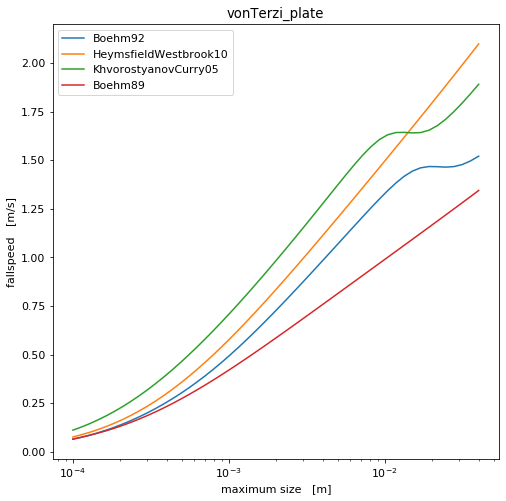

In [3]:
particle_type = 'vonTerzi_plate'
model_names = ['Boehm92', 'HeymsfieldWestbrook10', 'KhvorostyanovCurry05', 'Boehm89']

diameters   = np.logspace(-4,np.log10(4e-2))

#for plotting
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

for i_p, model_name in enumerate(model_names):

    #get particle properties from the database
    mass, vel, area = snowScatt.snowMassVelocityArea(diameters, particle_type, velocity_model=model_name) # This is the function to CALL!!
    axes.semilogx(diameters, vel, label=model_name)

axes.legend()
axes.set_title(particle_type)
axes.set_ylabel('fallspeed   [m/s]')
axes.set_xlabel('maximum size   [m]')

Now, let's try something fancy. Let's use the same particle properties and hydrodynamic model, but assume either increased mass or increased cross-section area. You will see that due to the scaling of the weight and drag forces

Text(0.5, 0, 'maximum size   [m]')

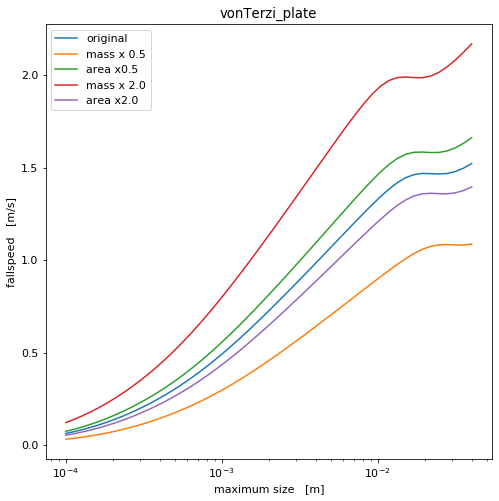

In [4]:
particle_type = 'vonTerzi_plate'
model_name = 'Boehm92'

diameters   = np.logspace(-4,np.log10(4e-2))
factors = [0.5, 2.0]
#for plotting
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

mass0, vel, area0 = snowScatt.snowMassVelocityArea(diameters, particle_type)
axes.semilogx(diameters, vel, label='original')
for i_p, factor in enumerate(factors):

    #get particle properties from the database
    
    mass, vel, area = snowScatt.snowMassVelocityArea(diameters, particle_type,
                                                     massVelocity=factor*mass0)
    axes.semilogx(diameters, vel, label='mass x '+str(factor))
    mass, vel, area = snowScatt.snowMassVelocityArea(diameters, particle_type,
                                                     areaVelocity=factor*area0)
    axes.semilogx(diameters, vel, label='area x'+str(factor))

axes.legend()
axes.set_title(particle_type)
axes.set_ylabel('fallspeed   [m/s]')
axes.set_xlabel('maximum size   [m]')

Go back to the [list of notebooks](../simple_usage.rst) for some other snow studies.